In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train_data_-400.csv
/kaggle/input/train_extend_5.csv
/kaggle/input/train_test_extend_7.csv
/kaggle/input/train_merged.csv
/kaggle/input/train_chunks_512.csv
/kaggle/input/train_test_extend_3.csv
/kaggle/input/train_extend_7.csv
/kaggle/input/test_extend_7.csv
/kaggle/input/test_extend_5.csv
/kaggle/input/test_extend.csv
/kaggle/input/test_extend_6.csv
/kaggle/input/train_extend.csv
/kaggle/input/test_extend_3.csv
/kaggle/input/train_merged_-400.csv
/kaggle/input/train_Collection5.json
/kaggle/input/test_extend_2.csv
/kaggle/input/train.json
/kaggle/input/train_extend_2.csv
/kaggle/input/train_extend_3.csv
/kaggle/input/train_test_extend_5.csv
/kaggle/input/train_test_extend_4.csv
/kaggle/input/train_test_extend_2.csv
/kaggle/input/train_test_extend_8.csv
/kaggle/input/train_data.csv
/kaggle/input/test_extend_8.csv
/kaggle/input/train_test_extend_6.csv
/kaggle/input/train_extend_6.csv
/kaggle/input/test_extend_4.csv
/kaggle/input/train_extend_4.csv
/kaggle/input/train_exte

In [2]:
!pip install seqeval
# !pip install wandb --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=22c514c6b15883475b7554bb645a714858f14fc810b54a141d8ed072653bccc4
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.metrics import f1_score, matthews_corrcoef
from IPython.display import clear_output
from nltk import pos_tag
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import KFold, StratifiedKFold
import os
from IPython.display import clear_output
import gc
import joblib

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = DeprecationWarning)
warnings.simplefilter(action = 'ignore', category = UserWarning)
warnings.simplefilter(action = 'ignore', category = RuntimeWarning)
warnings.filterwarnings("ignore", message = "numpy.dtype size changed")
warnings.filterwarnings("ignore", message = "numpy.ufunc size changed")
pd.options.mode.chained_assignment = None

from warnings import simplefilter
simplefilter(action = "ignore", category = pd.errors.PerformanceWarning)

import torch
import transformers

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig, BertForTokenClassification

from transformers import DebertaV2Tokenizer, DebertaV2ForTokenClassification

from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from transformers import AdamW, get_linear_schedule_with_warmup

from seqeval.metrics import accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm, trange

try:
    %load_ext autotime
except:
    pass 

clear_output(wait = False)

from pathlib import Path
Path("./models/").mkdir(parents = True, exist_ok = True)
Path("./val/").mkdir(parents = True, exist_ok = True)
Path("./results/checkpoint-last").mkdir(parents=True, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print(device, n_gpu)

# bert_name = "Babelscape/wikineural-multilingual-ner"
# bert_name = "sberbank-ai/ruBert-base"
# bert_name = 'bert-base-cased'
bert_name = "microsoft/mdeberta-v3-base"

MAX_LEN = 512
OVERLAP = 0.2

cuda 1


In [4]:
train_version = 8

# Чтение файла train_extend.csv в датафрейм
# df = pd.read_csv(f'/kaggle/input/train_extend_{train_version}.csv', sep=',')
df = pd.read_csv(f'/kaggle/input/train_test_extend_{train_version}.csv', sep=',')
# Преобразование значения в поле 'target_labels_positions' в словарь с помощью модуля ast
df['target_labels_positions'] = df['target_labels_positions'].map(ast.literal_eval)

target_labels = ['B-value', 'I-value', 'B-discount']

df

,processed_text,target_labels_positions,synthetic,row_label
0,аа союзная тридцать пять дробь один лариса сое...,{},0,0
1,аа приложение мне показывает к оплате у меня п...,{},0,0
2,да лисное по призрак лишнее ну почему иду пять...,"{'B-discount': [138, 212], 'B-value': [139], '...",0,2
3,а что добрый день NAME у меня пришел какой то ...,{'B-discount': [12]},0,1
4,у меня западный с утра да да еще да да самый в...,{},0,0
...,...,...,...,...
7895,самостоятельно угроза клиент хочет узнать о во...,"{'B-discount': [26], 'B-value': [29], 'I-value...",1,6
7896,сверкающий покидать жестокий единый клиент инт...,"{'B-discount': [146, 298], 'B-value': [147, 29...",1,6
7897,бочок боец кидать через изображать клиент инте...,"{'B-discount': [168], 'B-value': [161], 'I-val...",1,6
7898,затянуться возмутиться один клиент хочет узнат...,"{'B-discount': [169, 349], 'B-value': [164, 34...",1,6


In [5]:
sentences, labels, row_labels = [], [], []

for i, row in tqdm(df.iterrows(), total=len(df)):
    words = row['processed_text'].split()
    label_positions = row['target_labels_positions']
    word_labels = ['O'] * len(words)

    for label, positions in label_positions.items():
        for pos in positions:
            if 0 <= pos < len(words):
                word_labels[pos] = label

    sentences.append(words)
    labels.append(word_labels)
    row_labels.append(row['row_label'])

100%|██████████| 7900/7900 [00:00<00:00, 9332.82it/s]


In [6]:
print(sentences[2])

['да', 'лисное', 'по', 'призрак', 'лишнее', 'ну', 'почему', 'иду', 'пять', 'двух', 'полностью', 'последнего', 'да', 'да', 'да', 'и', 'там', 'есть', 'данные', 'надо', 'чтобы', 'стандартная', 'двух', 'что', 'была', 'пятьдесят', 'пятьдесят', 'десять', 'миллионов', 'три', 'а', 'первоначальный', 'вздох', 'сколько', 'вас', 'а', 'еще', 'какие', 'то', 'фиджи', 'приедем', 'там', 'сейчас', 'менеджера', 'да', 'вам', 'я', 'такая', 'там', 'проценты', 'а', 'если', 'не', 'столько', 'да', 'хорошо', 'конечно', 'и', 'это', 'заработал', 'хорошо', 'а', 'инвестое', 'отправьте', 'пожалуйстаздравствуйте', 'меня', 'зовут', 'на', 'менеджере', 'дело', 'продаж', 'группы', 'самолет', 'вы', 'рассматриваете', 'какой', 'то', 'определенный', 'комплекс', 'для', 'себя', 'что', 'хотели', 'просмотреть', 'сколько', 'комнат', 'двух', 'комнатная', 'квартира', 'так', 'давайте', 'посмотрим', 'я', 'вижу', 'вы', 'интересовались', 'ранее', 'да', 'этим', 'знаете', 'где', 'он', 'находится', 'о', 'там', 'есть', 'да', 'уже', 'готовы

In [7]:
print(labels[2])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-discount', 'B-value', 'I-value', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'

In [8]:
print(sentences[3394])

['у', 'тебя', 'сочиняешь', 'которая', 'там', 'ну', 'а', 'как', 'созвониться', 'вечером', 'потому', 'что', 'мне', 'сейчас', 'неудобно', 'разговариватьздравствуйте', 'группа', 'самолет', 'меня', 'зовут', 'NAME', 'как', 'могу', 'по', 'обращаться', 'приятно', 'NAME', 'она', 'себя', 'рассматривает', 'да', 'конечно', 'в', 'котором']


In [9]:
print(labels[3394])

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [10]:
tag_values = target_labels + ['O', 'PAD']
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag_values, len(tag_values)

(['B-value', 'I-value', 'B-discount', 'O', 'PAD'], 5)

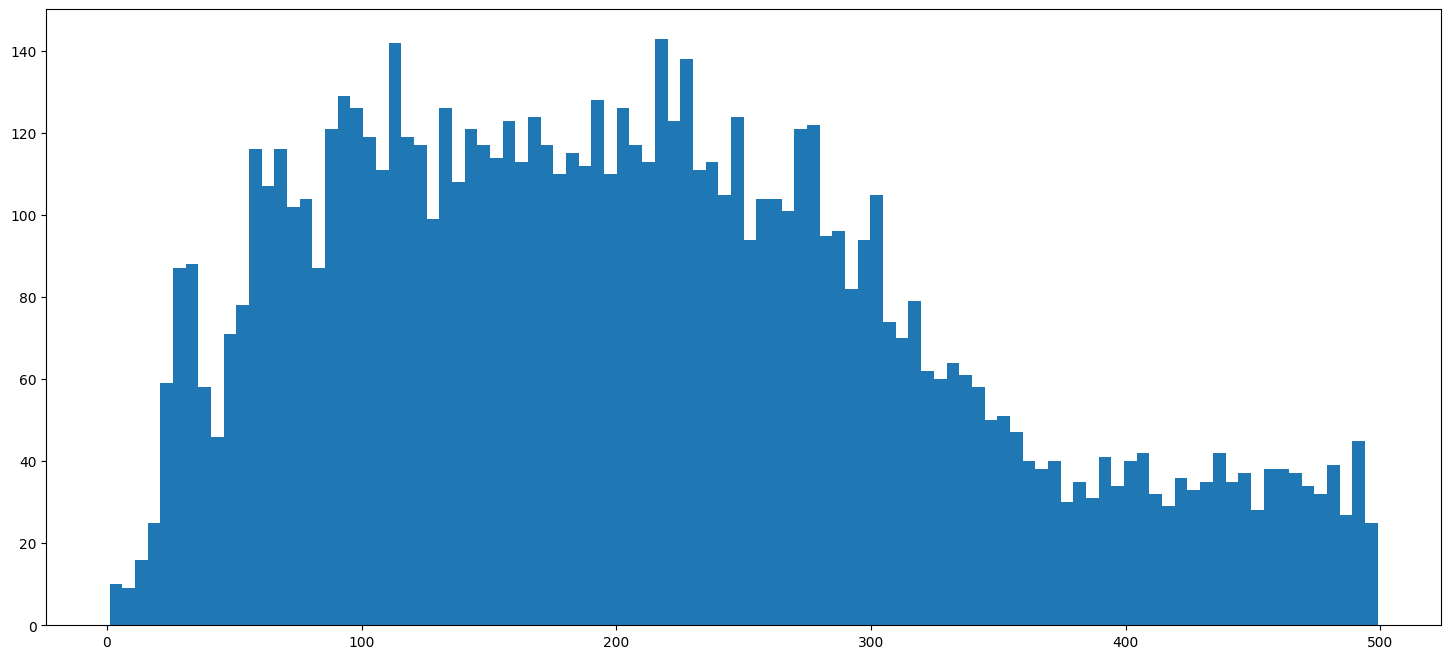

In [11]:
plt.figure(figsize=(18, 8))
plt.hist([len(s) for s in sentences], bins=100)
plt.show()

In [12]:
%%time
# tokenizer = BertTokenizer.from_pretrained(bert_name, do_lower_case = False)
tokenizer = DebertaV2Tokenizer.from_pretrained(bert_name, do_lower_case = False)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

CPU times: user 1.84 s, sys: 97.3 ms, total: 1.93 s
Wall time: 2.87 s


In [13]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [14]:
def split_sentence_with_overlap(s_words, s_labels, tokenizer,
                                max_len=MAX_LEN, overlap=OVERLAP):
    """
    Разделить предложение на части с перекрытием.
    :param s_words: предложение -> список слов для разделения
    :param s_labels: список меток слов
    :param tokenizer: экземпляр токенизатора
    :param max_len: максимальная длина части
    :param overlap: процент перекрытия
    :return: список частей предложения и список частей меток
    """
    chunk_size = max_len - 12  # Оставляем место для специальных токенов
    overlap_size = int(chunk_size * overlap)
    chunks = []
    start_index = end_index = 0
    while end_index < len(s_words):
        end_index = start_index + chunk_size
        chunk_words = s_words[start_index:end_index]
        chunk_text = ' '.join(chunk_words)

        # Токенизируем текст, чтобы убедиться в том, что длина в токенах не превышает max_len
        tokens = tokenizer.tokenize(chunk_text)
        while len(tokens) > chunk_size and len(chunk_words):
            chunk_words = chunk_words[:-1]
            chunk_text = ' '.join(chunk_words)
            tokens = tokenizer.tokenize(chunk_text)

        chunks.append((chunk_words,
                       s_labels[start_index: start_index + len(chunk_words)],
                       start_index))

        # У нас один чанк и нечего дальше крутить цикл - виснет
        if len(chunk_words) == len(s_words):
            break

        # найдем сколько слов входит в перекрытие для вычисления индекса смещения
        tokens = []
        overlap_index = 0
        reversed_words = chunk_words[::-1]
        # пока длина токенов перекрытия меньше размера перекрытия добавляем по одному слову
        while len(tokens) < overlap_size:
            overlap_index += 1
            tokens = tokenizer.tokenize(' '.join(reversed_words[:overlap_index]))

        end_index = start_index + len(chunk_words)
        # Следующая часть начинается с учетом перекрытия
        start_index += len(chunk_words) - overlap_index

    new_words, new_labels = [], []
    for chunk_words, chunk_labels, start_index in chunks:
        new_words.append(chunk_words)
        new_labels.append(chunk_labels)

    return new_words, new_labels


def split_sentences(sentences, labels, row_labels, tokenizer, max_len=MAX_LEN, overlap=OVERLAP):
    """
    Обработка списка списков предложений и списка списков меток
    :param sentences: список списков предложений
    :param labels: список списков меток
    :param row_labels: список меток предложений (нужно для стратификации)
    :param tokenizer: экземпляр токенизатора
    :param max_len: максимальная длина части
    :param overlap: процент перекрытия
    :return: новые списки предложений и меток
    """
    new_sentences, new_labels, new_row_labels, idx_rows = [], [], [], []

    print('Разделение предложений на части:')
    for idx, (s_words, s_labels, s_row) in tqdm(enumerate(zip(sentences, labels, row_labels)),
                                                total=len(sentences)):
        spl_snt, spl_lbl = split_sentence_with_overlap(s_words,
                                                       s_labels,
                                                       tokenizer,
                                                       max_len=max_len,
                                                       overlap=overlap)
        new_sentences.extend(spl_snt)
        new_labels.extend(spl_lbl)
        new_row_labels.extend([s_row] * len(spl_snt))
        idx_rows.extend([idx] * len(spl_snt))

    return new_sentences, new_labels, new_row_labels, idx_rows

In [15]:
# разделение длинных предложений на части, так чтобы одно предложение не выходило за предел MAX_LEN токенов

print(f'Количество предложений до: {len(sentences)}\n')

sentences, labels, row_labels, idx_rows = split_sentences(sentences, labels, row_labels,
                                                          tokenizer, overlap=0.25)

print(f'\nКоличество предложений после: {len(sentences)}')

Количество предложений до: 7900

Разделение предложений на части:


100%|██████████| 7900/7900 [08:30<00:00, 15.47it/s] 


Количество предложений после: 10102


In [16]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [17]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]

labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen = MAX_LEN, dtype = "long", value = 0.0,
                          truncating = "post", padding = "post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen = MAX_LEN, value = tag2idx["PAD"], padding = "post",
                     dtype = "long", truncating = "post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [18]:
def get_model():
    
    model = DebertaV2ForTokenClassification.from_pretrained(
        bert_name,
        num_labels = len(tag2idx),
        output_attentions = False,
        output_hidden_states = False,
        ignore_mismatched_sizes=True,
    )
    
    model.to(device)
    
    FULL_FINETUNING = True
    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=3e-5,
        eps=1e-8
    )    
    
    return model, optimizer

In [19]:
def train_model(name_model, best_score_total=0):
    
    epochs = 30
    max_grad_norm = 1.0

    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps = 0,
        num_training_steps = total_steps
    )
    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []
    best_score = 0
    not_increase = 0
    not_increase_stop = 5

    #for _ in trange(epochs, desc = "Epoch"):
    for epoch in range(epochs):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            # Перенос батча на GPU
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Убедитесь, что метки имеют тип LongTensor
            b_labels = b_labels.long()

            # Всегда очищайте любые ранее рассчитанные градиенты перед выполнением обратного прохода
            model.zero_grad()

            # Прямой проход
            outputs = model(
                b_input_ids, 
                token_type_ids=None,
                attention_mask=b_input_mask, 
                labels=b_labels
            )

            # Получение потерь
            loss = outputs[0]
            # Выполнение обратного прохода для расчета градиентов
            loss.backward()
            # Отслеживание тренировочных потерь
            total_loss += loss.item()
            # Ограничение нормы градиента
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # Обновление параметров
            optimizer.step()
            # Обновление скорости обучения
            scheduler.step()

            

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        #print("Average train loss: {}".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)
    
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions , true_labels = [], []
        for batch in tqdm(valid_dataloader):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(
                    b_input_ids, 
                    token_type_ids = None,
                    attention_mask = b_input_mask, 
                    labels = b_labels
                )
            # Move logits and labels to CPU
            logits = outputs[1].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences.
            eval_loss += outputs[0].mean().item()
            predictions.extend([list(p) for p in np.argmax(logits, axis = 2)])
            true_labels.extend(label_ids)

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
    
        #print("Validation loss: {}".format(eval_loss))
        pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                     for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
        valid_tags = [tag_values[l_i] for l in true_labels
                                      for l_i in l if tag_values[l_i] != "PAD"]
        score_val = f1_score(
                valid_tags, pred_tags, 
                labels = ['B-value', 'I-value', 'B-discount', 'O'], 
                average = 'macro'
        )
        #print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
        #print("Validation F1-Score: {}".format(score_val))
        if best_score < score_val:
            best_score = score_val         
            not_increase = 0         
            if best_score_total < best_score:
                best_score_total = best_score
                msg = f'save model, {best_score_total}, {score_val}'
                print(epoch, msg)
                
                # Save the fine-tuned model locally
                model.save_pretrained(f"./results/checkpoint-last")
                
                try:
                    Path(name_model).mkdir(parents = True, exist_ok = True)
                    model.save_pretrained(name_model)
                except:    
                    pass
            else:
                msg = f'... {best_score_total}, {score_val}'
                print(epoch, msg)
        else:
            not_increase += 1
            msg = f'not_increase = {not_increase}, {best_score}, {score_val}'
            print('epoch:', epoch, msg)
            if not_increase >= not_increase_stop:                
                print('not_increase = ', not_increase_stop)
                break
                
    return best_score_total

In [ ]:
SEEDS = 1
scores = []
batch_size = 4

best_score = 0 

folds = 5

for seed in (17,):    
    # kf = KFold(n_splits = 5, random_state = seed, shuffle = True)
    kf = StratifiedKFold(n_splits=folds, random_state=seed, shuffle=True)
    for fold, (train_index, val_index) in enumerate(kf.split(input_ids, row_labels)):
        
        test_index = sorted(set([idx_rows[i] for i in val_index]))
        df.iloc[test_index].to_csv(f'test_fold_{fold}.csv', index=False)
        
        clear_output(wait = False)
        print('SEEDS:', seed, 'Fold:', fold)
        print(np.mean(scores) - np.std(scores))
        
        tr_inputs  = input_ids[train_index]
        val_inputs = input_ids[val_index]
        
        tr_tags  = tags[train_index]
        val_tags = tags[val_index]
        
        tr_masks  = np.array(attention_masks)[train_index]
        val_masks = np.array(attention_masks)[val_index]
        
        tr_inputs = torch.tensor(tr_inputs)
        val_inputs = torch.tensor(val_inputs)

        tr_tags = torch.tensor(tr_tags, dtype=torch.long)
        val_tags = torch.tensor(val_tags, dtype=torch.long)

        tr_masks = torch.tensor(tr_masks)
        val_masks = torch.tensor(val_masks)
        
        train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
        
        valid_data = TensorDataset(val_inputs, val_masks, val_tags)
        valid_sampler = SequentialSampler(valid_data)
        valid_dataloader = DataLoader(valid_data, sampler = valid_sampler, batch_size = batch_size)
        
        model, optimizer = get_model()
        
        name_model = f'./best_model-{fold}-{folds}'
        score = train_model(name_model, best_score)
        scores.append(score)   
        best_score = score   
               
        del model, optimizer; gc.collect()     
        
        # хватит одного фолда
        break        
        
print(np.mean(scores) - np.std(scores))

Fold 0
nan


pytorch_model.bin:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/mdeberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 361/361 [00:39<00:00,  9.17it/s]


0 save model, 0.9307123293214201, 0.9307123293214201


100%|██████████| 361/361 [00:39<00:00,  9.18it/s]


1 save model, 0.9523516416315905, 0.9523516416315905


100%|██████████| 361/361 [00:39<00:00,  9.18it/s]


epoch: 2 not_increase = 1, 0.9523516416315905, 0.9509763219468501


100%|██████████| 361/361 [00:39<00:00,  9.18it/s]


epoch: 3 not_increase = 2, 0.9523516416315905, 0.9479347470500556


100%|██████████| 361/361 [00:39<00:00,  9.18it/s]


epoch: 4 not_increase = 3, 0.9523516416315905, 0.949241977350369


100%|██████████| 361/361 [00:39<00:00,  9.17it/s]


5 save model, 0.9546044428046511, 0.9546044428046511


100%|██████████| 361/361 [00:39<00:00,  9.18it/s]


epoch: 6 not_increase = 1, 0.9546044428046511, 0.9514314616527293


 49%|████▉     | 1057/2165 [06:24<06:43,  2.75it/s]

In [ ]:
from IPython.display import display, FileLink
from zipfile import ZipFile, ZIP_DEFLATED as ZD
from glob import glob

files = glob(f'results/checkpoint-last/*.*') + glob('*.csv')
zip_filename = f'model_mdeberta_{train_version}.zip'
with ZipFile(zip_filename, 'w',  compression=ZD, compresslevel=9) as zip_file:
    for filename in files:
        print(filename)
        zip_file.write(filename)
FileLink(zip_filename)